In [1]:
#-----------------------------------------
# Problem Set 2: Static Entry Model
#   Tanya Rajan and George Vojta
#-----------------------------------------

# importing packages
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import fsolve
from scipy.stats import logistic
from scipy.stats import expon
from scipy.special import expit
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

% Periods replaced:  8.16


<AxesSubplot:ylabel='Frequency'>

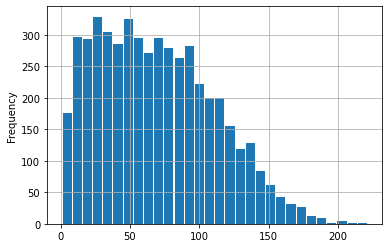

In [2]:
# ------------------------
#     Question 2.3
# ------------------------

# load data
df = pd.read_csv("psetTwo.csv")

# generating replacement variable
df['mlag'] = df['milage'].shift()
df['mlead'] = df['milage'].shift(-1)
df['d'] = (df['mlead'] - df['milage'] < 0)*1
print("% Periods replaced: ", np.mean(df['d'])*100)

# generating
df['diff'] = df['mlead'] - df['milage']
df.loc[df['d']==1, 'diff'] = df['mlead']
df['milage'].plot.hist(grid=True, bins=30, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

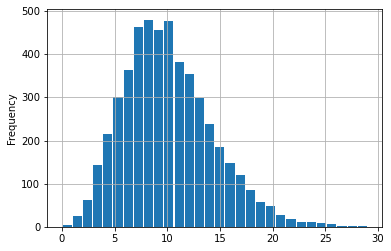

In [3]:
df['diff'].plot.hist(grid=True, bins=30, rwidth=0.9)

In [4]:
###### Discretizing the Domain ######

# Binning and setup
K = 10
df['bins'] = pd.cut(df['milage'], K, labels=range(K), include_lowest=True)
df['bins_lead'] = df['bins'].shift(-1)
df0 = df[df['d']==0].copy()
df1 = df[df['d']==1].copy()

# Constructing p matrix
F0 = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        F0[i,j] = len(df[(df['bins'] == i)  & (df['bins_lead'] == j)])/len(df[df['bins'] == i])

F0[0,:] = F0[0,:]/np.sum(F0[0,:]) 

# All bin intervals
all_bins = pd.cut(df['milage'], K, include_lowest=True).unique()

In [14]:
# ------------------------
#       Inner Loop
# ------------------------

# bin number to mileage (returns midpoint)
def bin2mile(b):
    return((all_bins[b].left + all_bins[b].right)/2)
b2m = np.vectorize(bin2mile)

    
# calculate u_j for j = 1, 2
def calc_u(θ, β, b):
    θ1, θ2, θ3 = θ
    x = b2m(b)
    #x=b
    u0 = -θ1*x - θ2*np.power((x/100), 2)
    u1 = -θ3
    return u0, u1

test_bins = np.array((0,1,2,3,4,5,6,7,8,9))
test_theta = np.array((10,20,30))

calc_u(test_theta, .999, test_bins)

(array([ -119.17772042,  -342.312     ,  -566.272     ,  -792.168     ,
        -1020.        , -1249.768     , -1481.472     , -1715.112     ,
        -1950.688     , -2188.2       ]),
 -30)

In [15]:
# pk function (probability of replacing)
def pk(θ, β, b, ev):
    # setup
    u0, u1 = calc_u(θ, β, b)
    
    # pk function
    v0 = u0 + β*ev
    v1 = u1 + β*ev[0]
    return expit(v1 - v0)

#test_ev = np.array((1, 2, 1, .5, .2, .5, .1, .3, 1, .3))
test_ev = np.array((1,2,3,4,5,6,7,8,9,10))
test_pk = pk(np.array((.01,.02,.03)), .99, 9, test_ev)
test_pk

array([0.89643255, 0.7628195 , 0.54443248, 0.30750706, 0.14163209,
       0.0577689 , 0.0222742 , 0.00839407, 0.00313558, 0.00116741])

In [34]:
# expected value equation
def G_obj(ev, θ, β, b, pmat):
    # setup
    u0, u1 = calc_u(θ, β, b)
    v0 = u0 + β*ev
    v1 = u1 + β*ev[0]
    vmax = np.maximum(v0, v1)
    
    # recentered EV function
    ev = pmat@(vmax + np.log(np.exp(v1 - vmax) + np.exp(v0 - vmax)))
    return ev
test_bins = np.array((0,1,2,3,4,5,6,7,8,9))
#test_ev = np.array((1, 2, 1, .5, .2, .5, .1, .3, 1, .3))
test_ev = np.array((1,2,3,4,5,6,7,8,9, 10))
G_obj(test_ev, np.array((.00358499936,1.59417885,8.2906255)), .999, 9, F0)

array([-5.94228625, -5.20229334, -4.30643121, -3.50366467, -2.91041854,
       -2.46841326, -2.38280346, -2.53521971, -1.98935082, -5.0957919 ])

In [17]:
# expected value jacobian
def G_jac(ev, θ, β, x, pmat):
    pkvec = pk(θ, β, x, ev)
    
    # derivative matrix
    k = pmat.shape[0]
    deriv = np.zeros((k,k))
    for i in range(k):
        deriv[i, 0] = pkvec[0]
        deriv[i, i] = 1-pkvec[i]
    deriv[0,:] = np.zeros(ev.size)
    deriv[0,0] = 1
    
    # multiply
    return(β*pmat@deriv)

test_bins = np.array((0,1,2,3,4,5,6,7,8,9))
#test_ev = np.array((1, 2, 1, .5, .2, .5, .1, .3, 1, .3))
test_ev = np.array((1,2,3,4,5,6,7,8,9, 10))
#G_jac(test_ev, np.array((.01,.02,.03)), .999, test_bins, F0)

In [35]:
# Rust Poly algorithm
def RustPoly(evguess, θ, β, x, pmat, tol1, imax1, tol2, imax2):
    # setup
    u0, u1 = calc_u(θ, β, x)
    
    # Step 1: Iteration
    count1 = 1
    ev_new = evguess
    diff1 = 1
    while (diff1 > tol1) and (count1 < imax1):
        ev_old = ev_new
        ev_new = G_obj(ev_old, θ, β, x, pmat)
        diff1 = np.max(np.abs(ev_new - ev_old))
        count1 += 1
        
    # Step 2: Newton Kantorovich
    count2 = 1
    evnk_new = ev_new
    diff2 = 1
    while (diff2 > tol2) and (count2 < imax2):
        evnk_old = evnk_new
        J = G_jac(evnk_old, θ, β, x, pmat)
        G = G_obj(evnk_old, θ, β, x, pmat)
        Gprime_inv = np.linalg.inv(np.eye(J.shape[0]) - J)
        evnk_new = evnk_old - Gprime_inv@(evnk_old - G)
        diff2 = np.max(np.abs(evnk_new - evnk_old))
        count2 += 1
        
    print(count1, diff1, count2, tol2)
    return evnk_new

test_bins = np.array((0,1,2,3,4,5,6,7,8,9))
test_ev = np.array((1, 2, 1, .5, .2, .5, .1, .3, 1, .3))
#test_ev = np.array((1,2,3,4,5,6,7,8,9, 10))
RustPoly(test_ev, np.array((.00358499936,1.59417885,8.2906255)), .999, test_bins, F0, 10e-6, 100, 10e-20, 10000)

100 1.0670145808609561 1584 1e-19


array([-1172.97679403, -1174.92250176, -1176.54330509, -1177.2889374 ,
       -1177.38443252, -1177.24856985, -1176.69332113, -1176.04896543,
       -1175.97675726, -1172.89676057])

In [21]:
# ------------------------
#       Outer Loop
# ------------------------

# likelihood function
def likelihood(θ, β, x_bins, pmat, evguess, d, x):
    
    # fixed point
    ev = RustPoly(evguess, θ, β, x_bins, pmat, tol1=10e-6, imax1=100, tol2=10e-30, imax2=10000)
    
    # likelihood
    pkvec = pk(θ, β, x_bins, ev)
    lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])
    
    #lik = np.zeros(x.size)
    #for i in range(x.size):
    #    pk_val = pk(θ, β, x[i], ev)[x[i]]
    #    lik[i] = d[i]*np.log(pk_val) + (1-d[i])*np.log(1-pk_val)
    #lik = d*np.log(pk_val) + (1-d)*np.log(pk_val)
    
    print(-np.sum(lik))
    return -np.sum(lik)

#test_ev = np.array((1, 2, 1, .5, .2, .5, .1, .3, 1, .3))
test_ev = np.array((1,2,3,4,5,6,7,8,9,10))
likelihood(np.array((0,0,0)), .999, test_bins, F0, test_ev, df['d'], df['bins'])

scipy.optimize.minimize(likelihood, np.array((.01, .01, .01)), args=(.999, test_bins, F0, test_ev, df['d'], df['bins']))


100 0.6267485655390459 64 1e-29
3465.735902799727
100 0.5019554817192713 1963 1e-29
5624.868783184304
100 0.5019553345138519 1937 1e-29
5624.872276427979
100 0.5019554812030051 1929 1e-29
5624.868817457675
100 0.5019554737543714 1932 1e-29
5624.868744246209
100 62.00693591932486 16 1e-29
97248.43672950144
100 62.0069349951973 10000 1e-29
97248.43528036278
100 62.00693591062736 10000 1e-29
97248.43670412716
100 62.00693591932395 168 1e-29
97248.43673558027
100 12.978427608213224 10000 1e-29
inf


<ipython-input-21-4547ec256de3>:13: RuntimeWarning: divide by zero encountered in log
  lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])


100 12.978426686043804 10000 1e-29
inf


/Users/tanyarajan/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


100 12.978427599518454 10000 1e-29
inf
100 12.978427608048605 10000 1e-29
inf
100 0.5019554817192713 1963 1e-29
5624.868783184304
100 0.5019553345138519 1937 1e-29
5624.872276427979
100 0.5019554812030051 1929 1e-29
5624.868817457675
100 0.5019554737543714 1932 1e-29
5624.868744246209
100 62.00693591932486 16 1e-29
97248.43672950144
100 21.953795221932978 10000 1e-29
inf


<ipython-input-21-4547ec256de3>:13: RuntimeWarning: divide by zero encountered in log
  lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])


100 10.678732847408583 10000 1e-29
inf
100 5.06263625923566 10000 1e-29
111040.23137196168
100 2.2693528633740243 10000 1e-29
21219.893391218215
100 0.6316905335454805 10000 1e-29
3994.8388155651865
100 0.6316903035441896 10000 1e-29
3994.836562500748
100 0.6316905324871698 10000 1e-29
3994.838784682057
100 0.6316905269206217 10000 1e-29
3994.8387945901104
100 0.03857431372254183 2018 1e-29
1819.912645642819
100 0.038573863079904847 2019 1e-29
1819.9142214848225
100 0.03857431105931575 2023 1e-29
1819.9126631681706
100 0.03857431072878992 2083 1e-29
1819.912633953585
100 7.563764066210979 10000 1e-29
inf


<ipython-input-21-4547ec256de3>:13: RuntimeWarning: divide by zero encountered in log
  lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])


100 7.5637649468006884 10000 1e-29
inf


/Users/tanyarajan/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


100 7.5637640744583905 10000 1e-29
inf
100 7.5637640665585195 10000 1e-29
inf
100 0.03857431372254183 2018 1e-29
1819.912645642819
100 0.038573863079904847 2019 1e-29
1819.9142214848225
100 0.03857431105931575 2023 1e-29
1819.9126631681706
100 0.03857431072878992 2083 1e-29
1819.912633953585
100 7.563764066210979 10000 1e-29
inf


<ipython-input-21-4547ec256de3>:13: RuntimeWarning: divide by zero encountered in log
  lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])


100 3.8816362045176334 10000 1e-29
inf
100 2.0299151181214086 10000 1e-29
inf
100 1.0799695629804233 10000 1e-29
inf
100 0.5687301394485189 1806 1e-29
2436.801863769194
100 0.06216970525451959 2166 1e-29
1794.879909808769
100 0.062170159859276986 2113 1e-29
1794.8813084423155
100 0.06216970801822086 10000 1e-29
1794.8799240942603
100 0.062169708247245214 2185 1e-29
1794.8798988421827
100 0.06597398551976585 10000 1e-29
1745.7393052255547
100 0.06597445275781144 2094 1e-29
1745.7406361483484
100 0.06597398840280988 2117 1e-29
1745.7393188321553
100 0.06597398839173874 2085 1e-29
1745.7392948808035
100 0.0758934532822213 1962 1e-29
1575.6647187823155
100 0.07589396917378721 10000 1e-29
1575.6657917849739
100 0.07589345663998337 10000 1e-29
1575.6647297401596
100 0.07589345571791561 10000 1e-29
1575.664710675124
100 0.03759335320736601 1684 1e-29
1262.6470711119573
100 0.03759398332514308 1633 1e-29
1262.647581887519
100 0.0375933577488643 10000 1e-29
1262.6470762604426
100 0.037593354756

      fun: 1049.3835820637228
 hess_inv: array([[ 6.56300943e-06, -3.41143632e-04,  2.72045421e-04],
       [-3.41143632e-04,  1.81131768e-02, -1.44450798e-02],
       [ 2.72045421e-04, -1.44450798e-02,  1.15210188e-02]])
      jac: array([-1.43432617e-03,  2.89916992e-04,  4.57763672e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 174
      nit: 25
     njev: 41
   status: 2
  success: False
        x: array([3.58499936e-03, 1.59417885e+00, 8.29806255e+00])

In [33]:
# likelihood function
def likelihood1(θ, β, x_bins, pmat, evguess, d, x):
    
    # fixed point
    ev = RustPoly(evguess, θ, β, x_bins, pmat, tol1=10e-6, imax1=100, tol2=10e-30, imax2=10000)
    print(ev)
    
    # likelihood
    pkvec = pk(θ, β, x_bins, ev)
    lik = d*np.log(pkvec[x]) + (1-d)*np.log(1-pkvec[x])
    
    #lik = np.zeros(x.size)
    #for i in range(x.size):
    #    pk_val = pk(θ, β, x[i], ev)[x[i]]
    #    lik[i] = d[i]*np.log(pk_val) + (1-d[i])*np.log(1-pk_val)
    #lik = d*np.log(pk_val) + (1-d)*np.log(pk_val)
    
    print(-np.sum(lik))
    return -np.sum(lik)
likelihood1(np.array((.00358499936,1.59417885,8.2906255)), .999, test_bins, F0, test_ev, df['d'], df['bins'])


100 1.0694178642048229 1617 1e-29
[-1172.97679403 -1174.92250176 -1176.54330509 -1177.2889374
 -1177.38443252 -1177.24856985 -1176.69332113 -1176.04896543
 -1175.97675726 -1172.89676057]
1049.3876205347137


1049.3876205347137

0.0035